In [1]:
import os
import glob
import pathlib

import matplotlib.pyplot as plt  
import numpy as np
import pandas as pd
import seaborn as sns  
import tensorflow as tf 
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

from tensorflow.keras import layers  
from tensorflow.keras import models  

In [2]:
tf.__version__

'2.7.0'

In [3]:
seed = 123
tf.random.set_seed(seed)
np.random.seed(seed)

In [6]:
DATA_PATH = '../../data/spcup_2022_training_part1'
Labeled_dir = '../../data/spcup_2022_training_part1/labels.csv'

In [7]:
label_df = pd.read_csv(Labeled_dir)
label_df.head()

,track,algorithm
0,00050dd7458cf08e594c797930696bce.wav,4
1,00070e7c531000d3dddc735d107275a9.wav,2
2,000f0711027a69b7f3886c2dbcb7d41f.wav,3
3,001e28e66dee24408aaf3480dfb95fbe.wav,1
4,001eee950f60613869544b72cd48fe97.wav,2


In [8]:
X, y = label_df['track'].values, label_df['algorithm'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

In [7]:
type(X_train)

numpy.ndarray

In [9]:
tmp_df = label_df.copy().set_index('track')
label_ser = tmp_df['algorithm']

In [10]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

In [11]:
primary_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
prm_val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [12]:
for element in primary_ds.as_numpy_iterator():
  print(element)
  break

(b'de403c03cd432bc6742631b350e836d0.wav', 2)


In [13]:
type(element[0])

bytes

In [14]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [15]:
# @tf.function
def get_label(file_path):
  # print(file_path, type(file_path))
  labels= label_df[label_df["track"]==file_path]['algorithm'].to_numpy().squeeze()
  return tf.convert_to_tensor(labels)

In [16]:
def get_waveform_and_label(file_path):
  # label = get_label(file_path)
  cpath = DATA_PATH + os.sep + file_path
  audio_binary = tf.io.read_file(cpath)
  waveform = decode_audio(audio_binary)
  return waveform

In [17]:
tf.compat.v1.enable_eager_execution()

In [18]:
assert tf.multiply(6, 7).numpy() == 42

In [19]:
AUTOTUNE = tf.data.AUTOTUNE
waveform_ds = primary_ds.map(
    # map_func=lambda x: tf.py_function(func=get_waveform_and_label, inp=[x], Tout=(tf.float32, tf.int64)),
    # map_func=lambda x,y: (tf.py_function(get_waveform_and_label, [x], tf.float32), y),
    map_func=lambda x,y: (get_waveform_and_label(x), y),
    num_parallel_calls=AUTOTUNE)

In [20]:
waveform_vds = prm_val_ds.map(
    # map_func=lambda x: tf.py_function(func=get_waveform_and_label, inp=[x], Tout=(tf.float32, tf.int64)),
    # map_func=lambda x,y: (tf.py_function(get_waveform_and_label, [x], tf.float32), y),
    map_func=lambda x,y: (get_waveform_and_label(x), y),
    num_parallel_calls=AUTOTUNE)

In [21]:
waveform_ds.element_spec

(TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

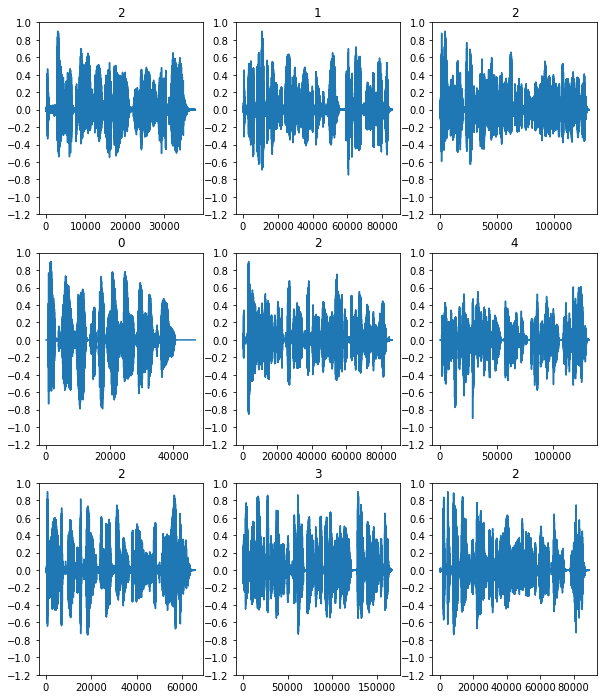

In [22]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy()
  ax.set_title(label)

plt.show()

In [23]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [24]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

C:\Users\deela\AppData\Local\Temp/ipykernel_53788/3600643975.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


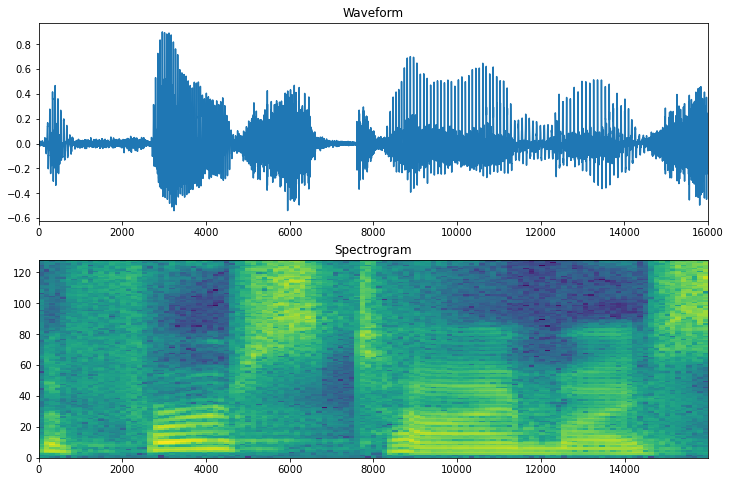

In [25]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy()
  spectrogram = get_spectrogram(waveform)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [26]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
#   label_id = tf.argmax(label == commands)
  return spectrogram, label

In [27]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

In [28]:
spectrogram_vds = waveform_vds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

In [29]:
spectrogram_ds.element_spec

(TensorSpec(shape=(None, 129, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

C:\Users\deela\AppData\Local\Temp/ipykernel_53788/3600643975.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


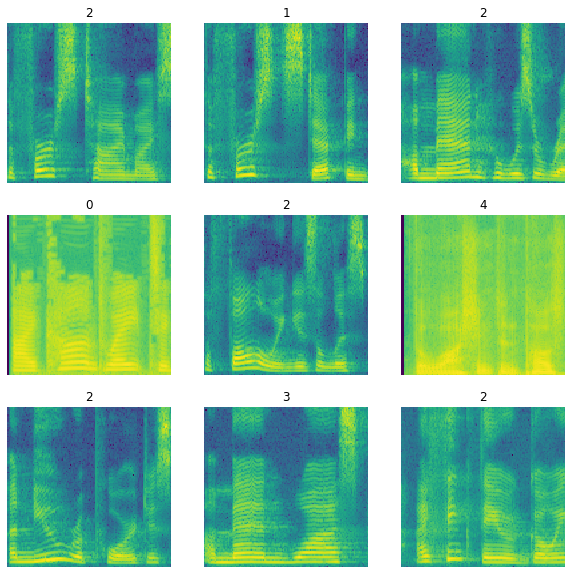

In [30]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(label_id.numpy())
  ax.axis('off')

plt.show()

In [31]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=lambda x: tf.py_function(func=get_waveform_and_label, inp=[x], Tout=(tf.float32, tf.int64)),
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [32]:
train_ds = spectrogram_ds
val_ds = spectrogram_vds

In [33]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [34]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)

Input shape: (124, 129, 1)


In [35]:
train_ds.element_spec

(TensorSpec(shape=(None, None, 129, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [40]:
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    # norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                      

In [41]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [42]:
EPOCHS = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
59/59 [==============================] - 2s 25ms/step - loss: 1.0595 - accuracy: 0.5787 - val_loss: 0.6271 - val_accuracy: 0.7496
Epoch 2/20
59/59 [==============================] - 1s 19ms/step - loss: 0.5641 - accuracy: 0.7683 - val_loss: 0.4577 - val_accuracy: 0.8024
Epoch 3/20
59/59 [==============================] - 1s 19ms/step - loss: 0.4279 - accuracy: 0.8301 - val_loss: 0.4018 - val_accuracy: 0.8248
Epoch 4/20
59/59 [==============================] - 1s 19ms/step - loss: 0.3296 - accuracy: 0.8680 - val_loss: 0.3266 - val_accuracy: 0.8648
Epoch 5/20
59/59 [==============================] - 1s 19ms/step - loss: 0.2680 - accuracy: 0.8976 - val_loss: 0.3258 - val_accuracy: 0.8672
Epoch 6/20
59/59 [==============================] - 1s 18ms/step - loss: 0.2371 - accuracy: 0.9029 - val_loss: 0.2835 - val_accuracy: 0.8832
Epoch 7/20
59/59 [==============================] - 1s 19ms/step - loss: 0.2005 - accuracy: 0.9219 - val_loss: 0.2805 - val_accuracy: 0.8832
Epoch 8/20
59